<a href="https://colab.research.google.com/github/Papa-Panda/paper_reading/blob/main/chapter_multilayer-perceptrons/mlp-concise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
# !pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l
!pip install d2l==1.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.8 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.2
    Uninstalling pyparsing-3.1.2:
      Successfully uninstalled pyparsing-3.1.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
  Attempting uninstall: matplotlib-inli

# 多层感知机的简洁实现
:label:`sec_mlp_concise`

本节将介绍(**通过高级API更简洁地实现多层感知机**)。


In [2]:
import torch
from torch import nn
from d2l import torch as d2l

## 模型

与softmax回归的简洁实现（ :numref:`sec_softmax_concise`）相比，
唯一的区别是我们添加了2个全连接层（之前我们只添加了1个全连接层）。
第一层是[**隐藏层**]，它(**包含256个隐藏单元，并使用了ReLU激活函数**)。
第二层是输出层。


In [3]:
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

[**训练过程**]的实现与我们实现softmax回归时完全相同，
这种模块化设计使我们能够将与模型架构有关的内容独立出来。


In [4]:
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)

In [6]:
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

loss 0.352, train acc 0.875, test acc 0.857
12085.5 examples/sec on None


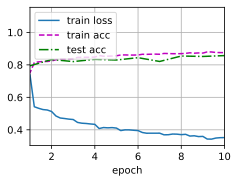

In [7]:
# https://github.com/d2l-ai/d2l-en/blob/master/d2l/torch.py
# d2l.train_ch6(net, train_iter, test_iter, loss, num_epochs, trainer)
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU.

    Defined in :numref:`sec_utils`"""
    if isinstance(net, nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # Required for BERT Fine-tuning (to be covered later)
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), d2l.size(y))
    return metric[0] / metric[1]


def train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer):
  # lr device
    """Train a model with a GPU (defined in Chapter 6).

    Defined in :numref:`sec_utils`"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    # print('training on', device)
    # net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=trainer.param_groups[0]['lr'])
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            # X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on None')

# d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## 小结

* 我们可以使用高级API更简洁地实现多层感知机。
* 对于相同的分类问题，多层感知机的实现与softmax回归的实现相同，只是多层感知机的实现里增加了带有激活函数的隐藏层。

## 练习

1. 尝试添加不同数量的隐藏层（也可以修改学习率），怎么样设置效果最好？
1. 尝试不同的激活函数，哪个效果最好？
1. 尝试不同的方案来初始化权重，什么方法效果最好？


[Discussions](https://discuss.d2l.ai/t/1802)
